# LFP example

In [1]:
import altair as alt
from bayes_window.generative_models import *
from bayes_window.visualization import plot_data, plot_data_slope_trials
from bayes_window import BayesWindow, models
try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass

## Make and visualize model oscillation power
40 trials of "theta power" is generated for every animal. It is drawn randomly as a poisson process.

This is repeated for "stimulation" trials, but poisson rate is higher. 

In [2]:
# Draw some fake data:
df, df_monster, index_cols, _ = generate_fake_lfp(mouse_response_slope=15, n_trials=30)

Mice vary in their baseline power.

Higher-baseline mice tend to have smaller stim response:

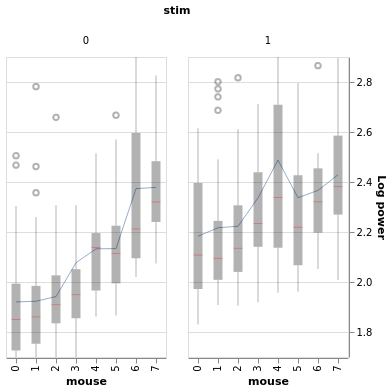

In [3]:
BayesWindow(df, y='Log power', treatment='stim', group='mouse').plot(x='mouse').facet(column='stim')


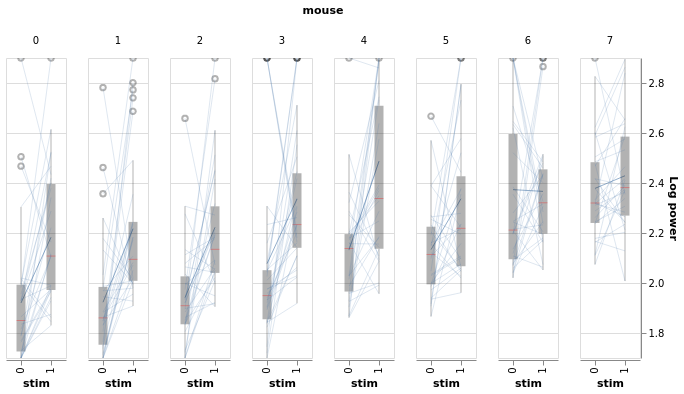

In [4]:
BayesWindow(df, y='Log power', treatment='stim', group='mouse', detail='i_trial').data_box_detail()

## Fit a Bayesian hierarchical model and plot slopes
In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](../motivation/parpooled.png)
This model allows intercepts to vary across mouse, according to a random effect. We just add a fixed slope for the predictor (i.e all mice will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where:
- $j$ is mouse index
- $i$ is observation index
- $y_i$ is observed power
- $x_i$ is 0 (no stimulation) or 1 (stimulation)
- $\epsilon_i \sim N(0, \sigma_y^2)$, error
- $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$, Random intercept

We set a separate intercept for each mouse, but rather than fitting separate regression models for each mouse, multilevel modeling **shares strength** among mice, allowing for more reasonable inference in mice with little data.

The wrappers in this library allow us to fit and plot this inference in just three lines of code. Under the hood, it uses the following Numpyro code:
```python
# Given: y, treatment, group, n_subjects
# Sample intercepts
a = sample('a', Normal(0, 1))
a_subject = sample('a_subject', Normal(jnp.tile(0, n_subjects), 1))

# Sample variances
sigma_a_subject = sample('sigma_a', HalfNormal(1))
sigma_obs = sample('sigma_obs', HalfNormal(1))

# Sample slope - this is what we are interested in!
b = sample('b_stim', Normal(0, 1))

# Regression equation
theta = a + a_subject[group] * sigma_a_subject + b * treatment

# Sample power
sample('y', Normal(theta, sigma_obs), obs=y)
```


Above is the contents of `model_hier_stim_one_codition.py`, the function passed as argument in line 4 below.

In [32]:
# Initialize:
from importlib import reload
from bayes_window import workflow
reload(workflow)
window=workflow.BayesWindow(df, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit_slopes(model=models.model_hierarchical,add_group_intercept=True,
                  add_group_slope=False,robust_slopes=False,
                  do_make_change='subtract', dist_y='gamma')

chart_power_difference = (window.chart+window.chart_posterior_kde).properties(title='Posterior')


n(Divergences) = 1


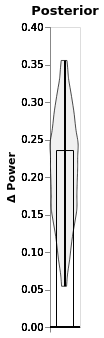

In [35]:
chart_power_difference


In this chart:

- The black line is the 94% posterior highest density interval

- Shading is posterior density

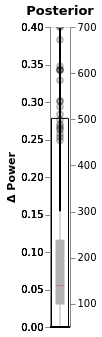

In [16]:
# TODO diff_y is missing from data_and posterior
# chart_power_difference_box
window.data_and_posterior.rename({'Power':'Power diff'},axis=1, inplace=True)
window.regression_charts(x=':O',independent_axes=True).properties(title='Posterior')
# window.chart

In this chart:

- The blue dot is the mean of posterior

- The black line is the 94% highest density interval

- The boxplot is made from difference between groups in the data (no fitting)

- Left Y scale is for posterior, right for data

## Compare to non-bayesian approaches
### Off-the-shelf OLS ANOVA

ANOVA does not pick up the effect of stim as significant:

In [7]:
window=BayesWindow(df, y='Log power', treatment='stim', group='mouse')
window.fit_anova();

Log_power~stim
           sum_sq    df     F  PR(>F)
stim        0.12   1.0  4.07    0.06
Residual    0.41  14.0   NaN     NaN


Including mouse as predictor helps

In [8]:
window.fit_anova(formula='Log_power ~ stim + mouse + mouse*stim');

Log_power ~ stim + mouse + mouse*stim
             sum_sq    df       F  PR(>F)
stim          0.12   1.0   37.78    0.00
mouse         0.36   1.0  112.85    0.00
mouse:stim    0.02   1.0    5.10    0.04
Residual      0.04  12.0     NaN     NaN


#### OLS ANOVA with heteroscedasticity correction

In [9]:
window.fit_anova(formula='Log_power ~ stim + mouse + mouse*stim', robust="hc3");

Log_power ~ stim + mouse + mouse*stim
             sum_sq    df       F  PR(>F)
stim          0.33   1.0  104.59    0.00
mouse         0.38   1.0  120.11    0.00
mouse:stim    0.01   1.0    2.46    0.14
Residual      0.04  12.0     NaN     NaN


A linear mixed-effect model shows the effect of stim (slope) as significant. It includes random intercepts of mouse:

In [10]:
# Initialize:
window=BayesWindow(df, y='Log power', treatment='stim', group='mouse')
window.fit_lme(add_data=False);

Using formula Log_power ~  C(stim, Treatment) + (1 | mouse)
                         Coef. Std.Err.       z  P>|z| [0.025 0.975]
Intercept                1.866    0.059  31.649  0.000  1.750  1.981
C(stim, Treatment)[T.1]  0.173    0.028   6.272  0.000  0.119  0.227
1 | mouse                0.062    0.013   4.982  0.000  0.038  0.087
Group Var                0.005    0.012                             


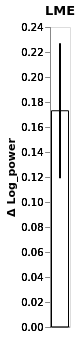

In [11]:
chart_power_difference_lme=window.regression_charts().properties(title='LME')
chart_power_difference_lme

## Compare LME and Bayesian slopes side by side

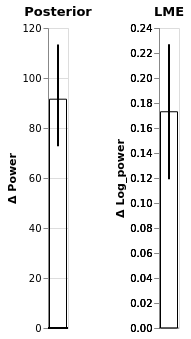

In [29]:
chart_power_difference|chart_power_difference_lme

## Inspect Bayesian result further
We named intercept _intercept_per_group_, so now we can plot it for each animal

In [27]:
# Initialize:
window=BayesWindow(df, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit_slopes(model=models.model_hierarchical,add_group_intercept=True,
                  add_group_slope=False,robust_slopes=False,
                  do_make_change='subtract', dist_y='gamma');

Please use window.create_regression_charts(): 'NoneType' object is not subscriptable


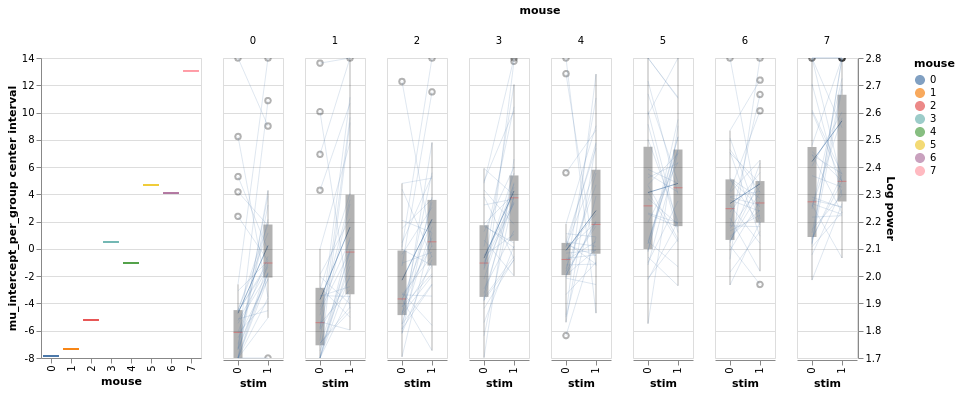

In [28]:
window.plot_slopes_intercepts(x='mouse');
chart_intercepts=window.posterior_intercept
chart_intercepts|BayesWindow(df, y='Log power', treatment='stim', group='mouse', detail='i_trial').data_box_detail()

Our plotting backend's flexibility allows us to easily concatenate multiple charts in the same figures with the | operator:

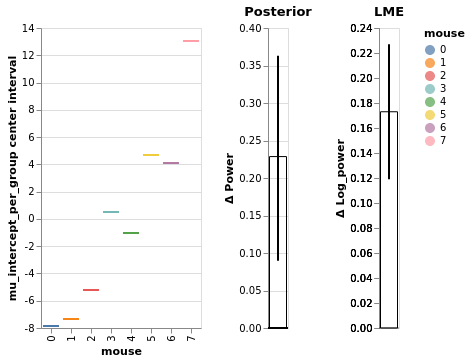

In [15]:
chart_intercepts | chart_power_difference | chart_power_difference_lme

## Check for false-positives with null model
They sometimes appear with non-transformed data + "normal" model

n(Divergences) = 2
Please use window.create_regression_charts(): 'NoneType' object is not subscriptable


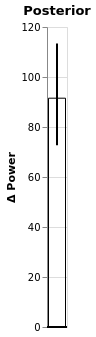

In [16]:
# Initialize:
from importlib import reload
from bayes_window import workflow
reload(workflow)
df_null, df_monster_null, index_cols, _ = generate_fake_lfp(mouse_response_slope=0, n_trials=30)
window=workflow.BayesWindow(df_null, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit_slopes(model=models.model_hierarchical,add_group_intercept=True,
                  add_group_slope=False,robust_slopes=False,
                  do_make_change='subtract', dist_y='normal');

# Plot:
chart_power_difference = window.plot(independent_axes=False,
                                    ).properties(title='Posterior')

chart_power_difference

This does not happen if we estimate group slopes. 

GLM is more robust to no differences in the case of no effect:

Please use window.create_regression_charts(): 'NoneType' object is not subscriptable


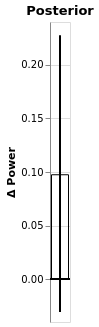

In [17]:
# Initialize:
window=BayesWindow(df_null, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit_slopes(model=models.model_hierarchical,add_group_intercept=True,
                  add_group_slope=False,robust_slopes=False,
                  do_make_change='subtract', dist_y='gamma');
# Plot:
window.plot(independent_axes=False,
           ).properties(title='Posterior')


## Include all samples in each trial
The mean of every one of the 30 trials we drew for each mouse is a manifestation of the same underlying process that generates power for each mouse. Let's try to include all samples that come in each trial

In [18]:
# NBVAL_SKIP
# Initialize:
window=BayesWindow(df_monster, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit_slopes(model=models.model_hierarchical,add_group_intercept=True,
                   num_warmup=500,n_draws=160,progress_bar=True,
                  add_group_slope=False,robust_slopes=False,
                  do_make_change='subtract', dist_y='gamma');

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

n(Divergences) = 1
Please use window.create_regression_charts(): 'NoneType' object is not subscriptable


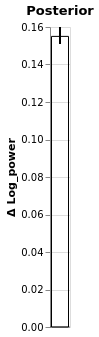

In [22]:
# NBVAL_SKIP
alt.data_transformers.disable_max_rows()
chart_power_difference_monster=window.plot(independent_axes=False).properties(title='Posterior')
chart_power_difference_monster

Much tighter credible intervals here!

Same with linear mixed model:

Using formula Log_power ~  C(stim, Treatment) + (1 | mouse)
                         Coef. Std.Err.       z  P>|z| [0.025 0.975]
Intercept                1.891    0.060  31.662  0.000  1.774  2.008
C(stim, Treatment)[T.1]  0.155    0.002  67.860  0.000  0.151  0.160
1 | mouse                0.060    0.013   4.617  0.000  0.035  0.086
Group Var                0.007    0.014                             


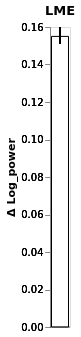

In [23]:
# NBVAL_SKIP
window=BayesWindow(df_monster,
                   y='Log power', treatment='stim', group='mouse')
window.fit_lme()


chart_power_difference_monster_lme=window.regression_charts().properties(title='LME')
chart_power_difference_monster_lme

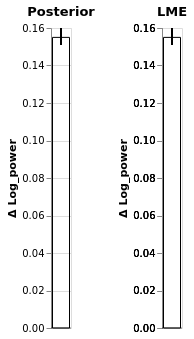

In [24]:
# NBVAL_SKIP
chart_power_difference_monster | chart_power_difference_monster_lme